In [2]:
# Import all necessary libraries.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
from datetime import datetime
from scipy.special import expit
from sklearn.datasets import make_moons
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score
tf.disable_v2_behavior()

In [3]:
# Define the number of examples.
N = 1000

# Create the dataset.
X, y = make_moons(N, noise=0.1, random_state=42)

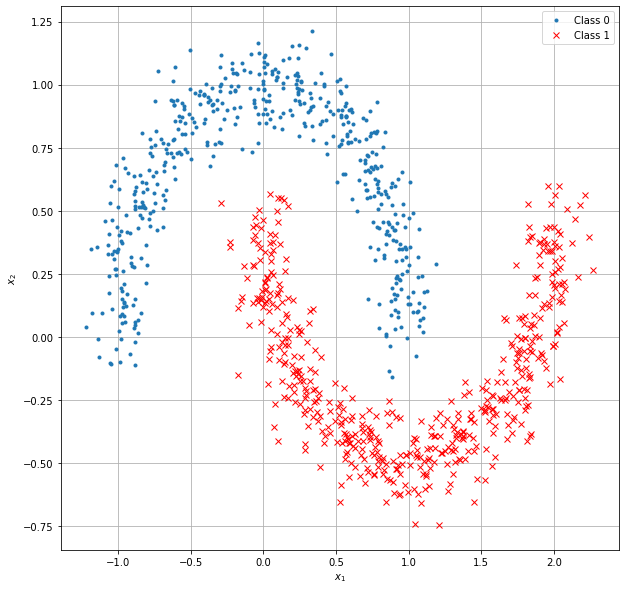

In [4]:
# Data Plot
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)

fig = plt.figure(figsize=(10,10))
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()

## Splitting of Training Data

In [5]:
y_vector = y.reshape(-1, 1)

# Split array into random train and test subsets.
x_train, x_test, y_train, y_test = train_test_split(X, y_vector, test_size=0.20, random_state=42)

print(f"Train data size is {x_train.shape}, train data label size is {y_train.shape}")
print(f"Test data size is {x_test.shape}, test data label size is {y_test.shape}")

Train data size is (800, 2), train data label size is (800, 1)
Test data size is (200, 2), test data label size is (200, 1)


## Hypothesis Funtion

In [6]:
x_train_h = np.c_[np.ones((len(y_train), 1)), x_train, x_train**2, x_train**3]
x_test_h = np.c_[np.ones((len(y_test), 1)), x_test, x_test**2, x_test**3]

print(f"Train data size is {x_train_h.shape}, train data label size is {y_train.shape}")
print(f"Test data size is {x_test_h.shape}, test data label size is {y_test.shape}")

Train data size is (800, 7), train data label size is (800, 1)
Test data size is (200, 7), test data label size is (200, 1)


## Training Stochastic Descending Gradient

In [7]:
# Getting the random index number
def select_random_batch(X, y):
    random_index = np.random.randint(N)
    X_i = X[random_index:random_index+1]
    y_i = y[random_index:random_index+1]
    return X_i, y_i

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

## Print Model Error (loss)

In [8]:
reset_graph()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs2"
logdir = "{}/run-{}/".format(root_logdir, now)

# Number of Features
input_number = 6

# Place holder for training data X
X = tf.placeholder(tf.float32, shape =(None, input_number + 1), name = "X" ) 

# Place holder for training label data y
y = tf.placeholder(tf.float32, shape =(None, 1), name = "y" ) 

# Initialize the Random value for theta
theta = tf.Variable(tf.random_uniform([input_number + 1, 1], -1.0, 1.0, seed=42), name="theta") #Initialize the Random value for theta
y_pred = tf.matmul(X, theta, name="predictions")

# Tensorflow Operations
logits = tf.matmul(X, theta, name="logits") 

# Calculate the probability
y_proba = tf.sigmoid(logits) 

# Loss function
loss = tf.losses.log_loss(y, y_proba) 

learning_rate = 0.02
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

epochs = 2000

train_summary = tf.summary.scalar('Training', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(epochs):
        for idx in range(N):
            X_i, y_i = select_random_batch(x_train_h, y_train)
            sess.run(training_op, feed_dict={X: X_i, y: y_i})
            loss_val = loss.eval({X: x_test_h, y: y_test})
        if epoch % 100 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            y_proba_val = y_proba.eval(feed_dict={X: x_test_h, y: y_test})
                                    
    best_theta = theta.eval()
    save_path = saver.save(sess, "/tmp/my_model_final.ckpt")                           

file_writer.close()                                    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch: 0 	Loss: 0.2965591
Epoch: 100 	Loss: 0.030251699
Epoch: 200 	Loss: 0.0200072
Epoch: 300 	Loss: 0.015679974
Epoch: 400 	Loss: 0.012979427
Epoch: 500 	Loss: 0.012040782
Epoch: 600 	Loss: 0.011432368
Epoch: 700 	Loss: 0.009871554
Epoch: 800 	Loss: 0.009386372
Epoch: 900 	Loss: 0.008242791
Epoch: 1000 	Loss: 0.008219183
Epoch: 1100 	Loss: 0.0075833257
Epoch: 1200 	Loss: 0.0069234357
Epoch: 1300 	Loss: 0.006954495
Epoch: 1400 	Loss: 0.006455997
Epoch: 1500 	Loss: 0.006415971
Epoch: 1600 	Loss: 0.006216962
Epoch: 1700 	Loss: 0.0061327685
Epoch: 1800 	Loss: 0.005678092
Epoch: 1900 	Loss: 0.005584529


## Restore the Last Checkpoint and Initiation

In [9]:
with tf.Session() as sess:
    saver.restore(sess, "/tmp/my_model_final.ckpt")
    best_theta_restored = theta.eval()
    
np.allclose(best_theta, best_theta_restored)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/my_model_final.ckpt


True

## Calculating Model Precision

In [10]:
y_pred = (y_proba_val >= 0.5)
precision_score(y_test, y_pred)

1.0

## Ploting training dataset

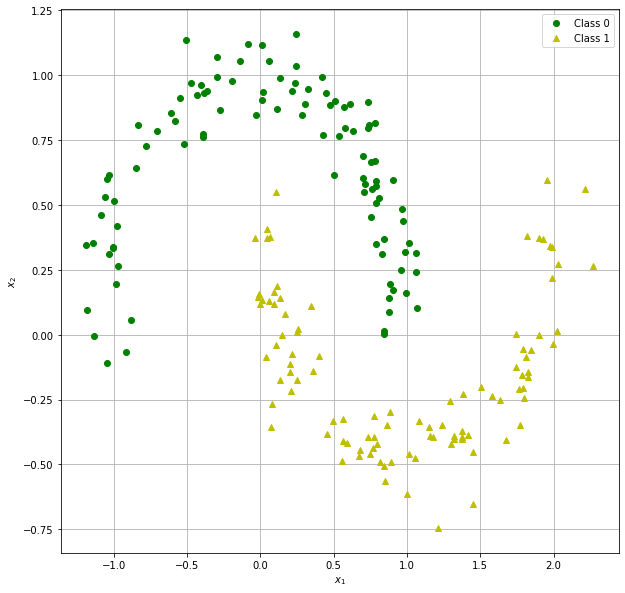

In [12]:
# 1D Array 
y_pred_idx = y_pred.reshape(-1) 

idx0 = np.argwhere(y_pred_idx == 0)
idx1 = np.argwhere(y_pred_idx == 1)

fig = plt.figure(figsize=(10,10))
plt.plot(x_test[idx0,0], x_test[idx0,1], 'go', label='Class 0')
plt.plot(x_test[idx1,0], x_test[idx1,1], 'y^', label='Class 1')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()

## TensorBoard notebook extension

In [13]:
%load_ext tensorboard
#%reload_ext tensorboard

In [14]:
%tensorboard --logdir tf_logs
#!kill 14672

Reusing TensorBoard on port 6006 (pid 22112), started 4:33:10 ago. (Use '!kill 22112' to kill it.)